
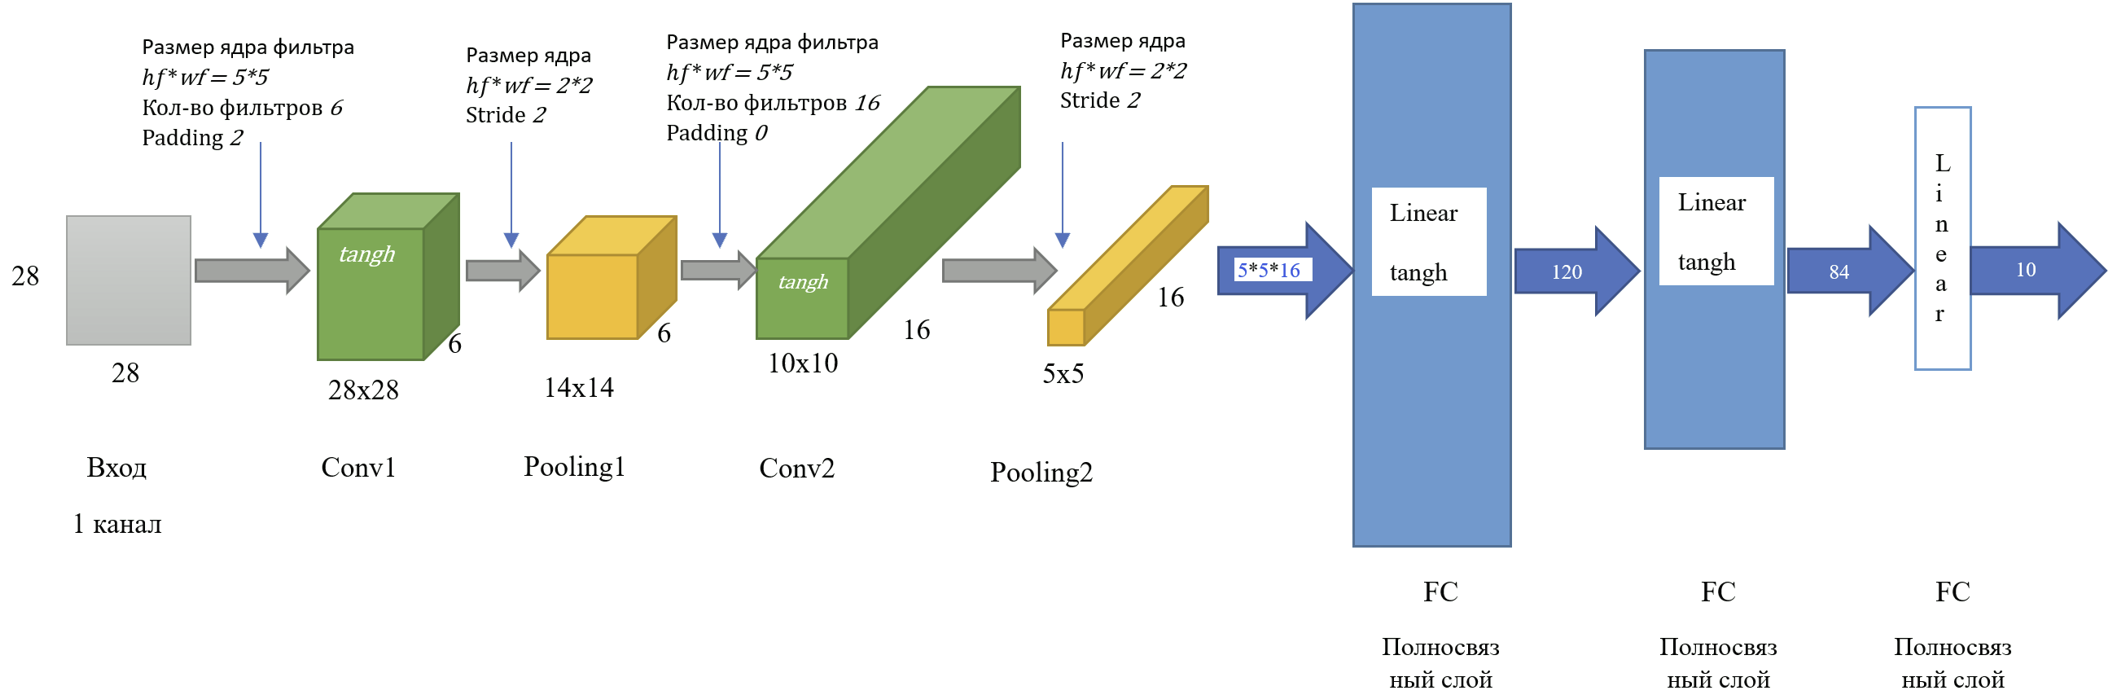


In [58]:
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [59]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'

In [61]:
import torchvision.datasets

In [62]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [63]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(num_output_channels=1)
])

In [64]:
# загружаем датасет в трейн и тест
train = torchvision.datasets.DTD(
    root='/DTD',
    download=True,
    transform=transform,
    split='train')
test = torchvision.datasets.DTD(
    root='/DTD',
    download=True,
    transform=transform,
    split='test')

In [65]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train)
test_loader = DataLoader(dataset=test)

In [66]:
X_list=[]
y_list=[]

for image, label in train_loader:
  X_list.append(image)
  y_list.append(label)

X_train = torch.cat(X_list)
y_train = torch.cat(y_list)

In [67]:
X_list.clear()
y_list.clear()

for image, label in test_loader:
  X_list.append(image)
  y_list.append(label)

X_test = torch.cat(X_list)
y_test = torch.cat(y_list)

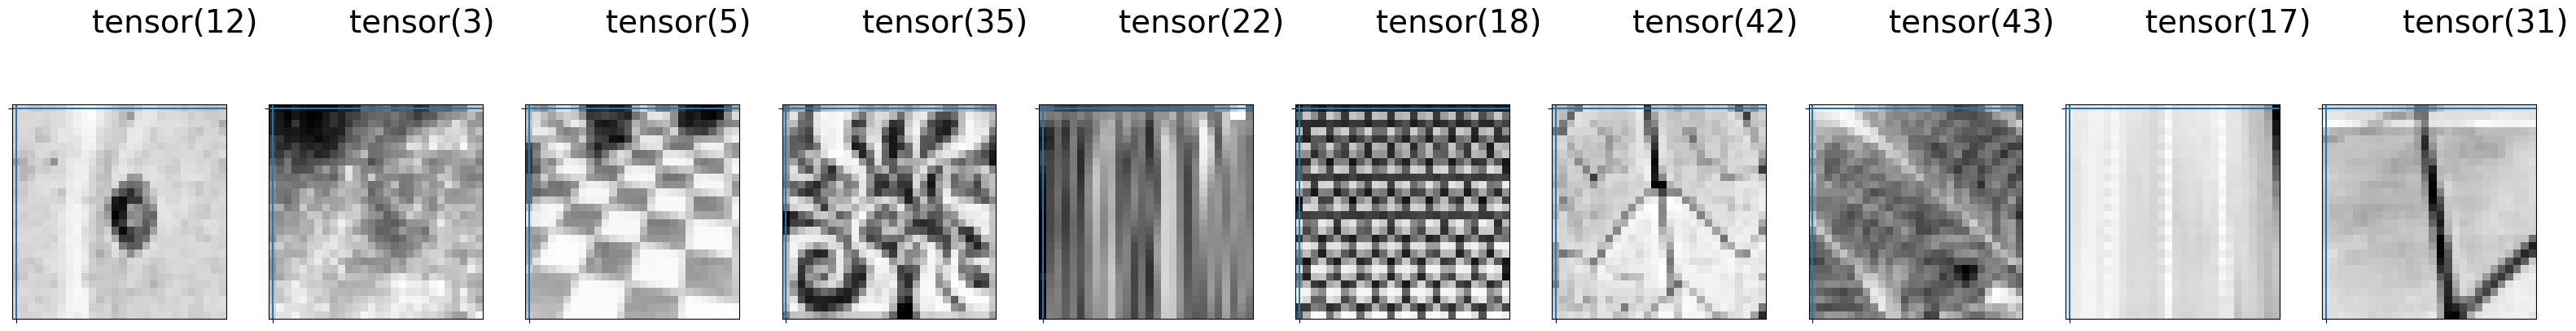

In [71]:
import numpy as np
import matplotlib.pyplot as plt

count = 0
sample_size = 10  # сколько картинок будем смотреть
plt.figure(figsize=(40, 20))
for i in np.random.permutation(len(X_train))[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=28)
    image = torchvision.transforms.ToPILImage()((X_train[i]*255).byte())
    plt.imshow(image, cmap=plt.cm.Greys)
plt.show()

In [73]:
y_train.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])

In [81]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, 5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        self.fc3   = torch.nn.Linear(84, 47)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [82]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [85]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        # обязательно обнуляем градиенты
        optimizer.zero_grad()
        # берем пачку параметров
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        # делаем предсказание
        preds = lenet5.forward(X_batch)
        # считаем лосс значение
        loss_value = loss(preds, y_batch)
        # берем градиенты
        loss_value.backward()
        # и пусть оптимайзер все оптимизирует
        optimizer.step()

    # смотрим, что он тут нам напредсказывал, не забывая вовремя отправлять на cpu
    train_loss_history.append(loss_value.data.cpu())

    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(f"epoch{epoch} - accuracy test {accuracy} ")

epoch0 - accuracy test 0.021808510646224022 
epoch1 - accuracy test 0.03510638326406479 
epoch2 - accuracy test 0.03882978484034538 
epoch3 - accuracy test 0.03776595741510391 
epoch4 - accuracy test 0.03882978484034538 
epoch5 - accuracy test 0.04414893314242363 
epoch6 - accuracy test 0.043617021292448044 
epoch7 - accuracy test 0.04680851101875305 
epoch8 - accuracy test 0.0452127642929554 
epoch9 - accuracy test 0.04680851101875305 
epoch10 - accuracy test 0.04734042286872864 
epoch11 - accuracy test 0.05319148674607277 
epoch12 - accuracy test 0.05106382817029953 
epoch13 - accuracy test 0.05531914532184601 
epoch14 - accuracy test 0.058510635048151016 
epoch15 - accuracy test 0.05425531789660454 
epoch16 - accuracy test 0.052659571170806885 
epoch17 - accuracy test 0.05478723347187042 
epoch18 - accuracy test 0.05425531789660454 
epoch19 - accuracy test 0.05106382817029953 
epoch20 - accuracy test 0.05638297647237778 
epoch21 - accuracy test 0.0521276593208313 
epoch22 - accuracy

<ipython-input-86-fd538a322c0e>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


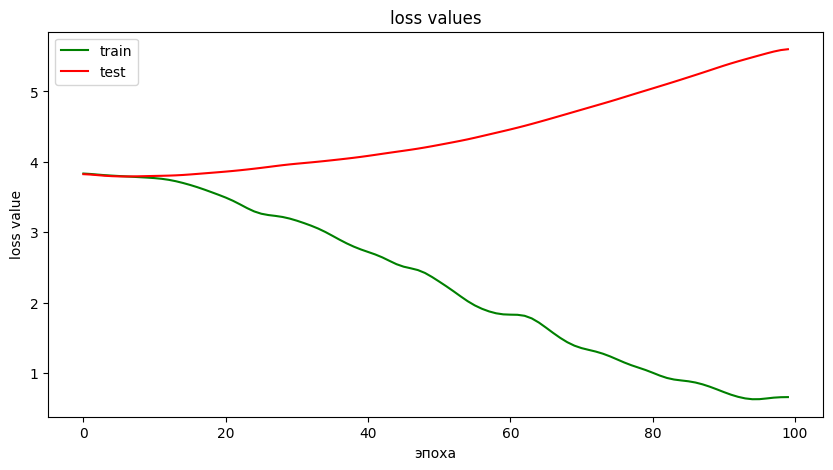

In [86]:
# строим графики - функции потерь

from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=2)
ax.plot(train_loss_smoothed, color='green',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=2)
ax.plot(test_loss_smoothed, color='red',  label='test')
ax.legend()
plt.show()



<ipython-input-88-7ea75e20b699>:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


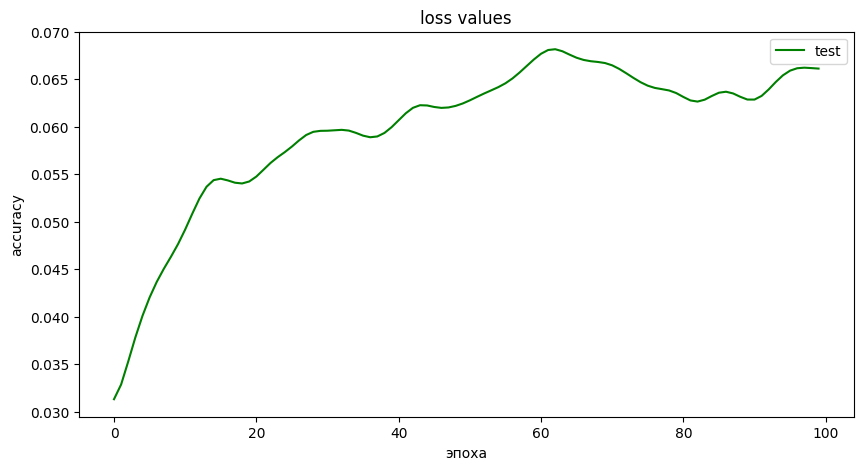

In [88]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'эпоха',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='green',  label='test')

ax.legend()
plt.show()